<a href="https://colab.research.google.com/github/MarcoSteuri/music_speech_classification/blob/main/NN_sound_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import modules and load functions

In [1]:
# Source functions und Transformationen zu tensorflow dataset: https://github.com/jkcas22/music_speech/blob/main/RNN.ipynb

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
#from tensorflow.keras import regularizers
from scipy.signal import hann
from scipy.io import wavfile
	
def get_mag_phs(re_im):
    mag_phs=[]
    for c in re_im:
        re=c[0]
        im=c[1]
        mag_phs.append([np.sqrt(re**2 + im**2), np.angle(re + im * 1j)])
    return np.array(mag_phs)


def get_logmag(re_im):
    logmag=[]
    for c in re_im:
        re=c[0]
        im=c[1]
        logmag.append(np.log(np.sqrt(re**2 + im**2)))
    return np.array(logmag)


def get_re_im(mag_phs):
    re_im=[]
    for c in mag_phs:
        mag=c[0]
        phs=c[1]
        re_im.append([mag * np.cos(phs), mag * np.sin(phs)])
    return np.array(re_im)


def load_wav(filenames):
    wl=[]
    for name in filenames:
        _, w = wavfile.read(name)
        w = w.astype(np.float32)
        norm = np.max(np.abs(w))
        w = w / norm
        w -= np.mean(w)
        wl.append(w)
    return np.array(wl)


def dft(sounds, fft_chunks, fft_step=256, fft_size=512):
    #fft_chunks = len(sounds[0]) // fft_step
    hann_win = hann(fft_size)
    re_im = []
    for signal in sounds:
        s = []
        for i in range(fft_chunks):
            frame = signal[(i * fft_step):(i * fft_step + fft_size)]
            frame = np.pad(frame, (0, fft_size - len(frame)), 'constant')
            frame *= hann_win
            s.append(frame)
        s = np.array(s)
        N = s.shape[-1]
        k = np.reshape(np.linspace(0.0, 2 * np.pi / N * (N // 2), N // 2), [1, N // 2])
        x = np.reshape(np.linspace(0.0, N - 1, N), [N, 1])
        freqs = np.dot(x, k)
        reals = np.dot(s, np.cos(freqs)) * (2.0 / N)
        imags = np.dot(s, np.sin(freqs)) * (2.0 / N)
        re_im.append([reals,imags])
    return np.array(re_im)


def dft_logmag(sounds, fft_chunks, fft_step=256, fft_size=512):
    re_im = dft(sounds, fft_chunks, fft_step, fft_size)
    return get_logmag(re_im)


def idft(re, im, step_size=256, fft_size=512):
	N = re.shape[1] * 2
	k = np.reshape(np.linspace(0.0, 2 * np.pi / N * (N // 2), N // 2), [N // 2, 1])
	x = np.reshape(np.linspace(0.0, N - 1, N), [1, N])
	freqs = np.dot(k, x)
	signal = np.zeros((re.shape[0] * step_size + fft_size,))
	recon = np.dot(re, np.cos(freqs)) + np.dot(im, np.sin(freqs))
	for hop_i, frame in enumerate(recon):
		signal[(hop_i * step_size): (hop_i * step_size + fft_size)] += frame
	return signal

# Load files

In [2]:
#mount google drive when on google colab and set working directory
import sys

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/CAS/M6/Music_speech/')

working_dir = os.getcwd()
print(f'\nWorking directory: {working_dir}')

Mounted at /content/drive

Working directory: /content/drive/MyDrive/CAS/M6/Music_speech


In [3]:
#Load music
music_dir = './data/music_wav'
if not os.path.isdir(music_dir): 
    print(f'copy folder "music_wav" from unzipped 34.tar to {os.path.join(working_dir, "data","")}')
#Keep files for final test
music_test = [
    'unpoco.wav',
    'blues.wav',
    'gismonti.wav',
    'ipanema.wav',
    'deedee.wav',
    'hendrix.wav',
    'madradeus.wav',
    'marlene.wav',
    'beatles.wav',
    'bagpipe.wav',
    'redhot.wav',
    'jazz.wav'
]
music_test = [os.path.join(music_dir, file) for file in music_test]

#List with path to all music files:
music = [os.path.join(music_dir, file_i) for file_i in os.listdir(music_dir) if file_i.endswith('.wav')]
music = list(set(music)-set(music_test))
print(f"Music files: {len(music)}, for final test: {len(music_test)}")

speech_dir = './data/speech_wav'
if not os.path.isdir(speech_dir): 
    print(f'copy folder "speech_wav" from unzipped 34.tar to {os.path.join(working_dir, "data","")}')

speech_test = [
    'comedy.wav',
    'thlui.wav',
    'voices.wav',
    'conversion.wav',
    'china.wav',
    'vegetables2.wav',
    'amal.wav',
    'teachers2.wav',
    'chant.wav',
    'pulp2.wav',
    'acomic.wav',
    'kid.wav'
]
speech_test = [os.path.join(speech_dir, file) for file in speech_test]

speech = [os.path.join(speech_dir, file_i) for file_i in os.listdir(speech_dir) if file_i.endswith('.wav')]
speech = list(set(speech)-set(speech_test))
		  
print(f"Speech files: {len(speech)}, for final test: {len(speech_test)}")


Music files: 52, for final test: 12
Speech files: 52, for final test: 12


# Assign labels and create tensorflow datasets

In [4]:
#Create numpy arrays with labels (0 for music, 1 for speech)
test = speech_test + music_test
test_labels = np.zeros(len(test))
test_labels[0:len(speech_test)]=1

split = len(speech)*8//10

train = speech[:split] + music[:split]
train_labels = np.zeros(len(train))
train_labels[:split]=1

validate = speech[split:] + music[split:]
validate_labels = np.zeros(len(validate))
validate_labels[:len(speech[split:])]=1



In [ ]:
test_sounds = load_wav(test) #Sampled at a rate of 55050 Hz. Hz = Anzahl der Schwingungen pro Sekunde.
test_sounds.shape #30 * 22050 = 661500 samples. (sampled at a rate of 22050 Hz)
train_sounds = load_wav(train)
validate_sounds = load_wav(validate)

In [ ]:
plt.plot(train_sounds[0])
plt.show()

In [ ]:
fft_step=256
fft_size=512
fft_chunks = len(train_sounds[0])//fft_step

test_logmag = dft_logmag(test_sounds,fft_chunks,fft_step,fft_size)
train_logmag = dft_logmag(train_sounds,fft_chunks,fft_step,fft_size)
validate_logmag = dft_logmag(validate_sounds,fft_chunks,fft_step,fft_size)

In [ ]:
plt.imshow(train_logmag[0].T)
plt.xlabel('t')
plt.ylabel('frequency')
plt.show()

In [ ]:
patch_step = 32 #32
patch_size = 64 #64

def ds_window(sound, label, patch_step, patch_size):
    labels = np.ones(len(sound))*label
    sound = np.c_[sound,labels]
    ds = tf.data.Dataset.from_tensor_slices(sound)
    ds = ds.window(size=patch_size,shift=patch_step,drop_remainder=True)
    ds = ds.flat_map(lambda x: x.batch(patch_size))
    return ds

def ds_patches(sounds, labels, patch_step, patch_size):
    ds = ds_window(sounds[0],labels[0],patch_step,patch_size)
    for sound, label in zip(sounds[1:],labels[1:]): ds = ds.concatenate(ds_window(sound,label,patch_step,patch_size))
    ds = ds.map(lambda x: (x[:,:-1], x[0,-1]))
    return ds

test_ds = ds_patches(test_logmag, test_labels, patch_step, patch_size)
train_ds = ds_patches(train_logmag, train_labels, patch_step, patch_size)
validate_ds = ds_patches(validate_logmag, validate_labels, patch_step, patch_size)

n_test = test_logmag.shape[0]*(((test_logmag.shape[1]-patch_size)//patch_step)+1)
n_train = train_logmag.shape[0]*(((train_logmag.shape[1]-patch_size)//patch_step)+1)
n_validate = validate_logmag.shape[0]*(((validate_logmag.shape[1]-patch_size)//patch_step)+1)

print(f"{n_test} samples for test.")
print(f"{n_train} samples for training.")
print(f"{n_validate} samples for validation.")
print(f"type of test_ds: {type(test_ds)}")

In [ ]:
n = 10
for sound, label in train_ds.take(n):
    sound = sound.numpy()
    print(f"{sound.shape} : {sound[[0,patch_step],0]} : {sound[[-patch_step-1,-1],0]}")

In [ ]:
for i, (sound, label) in enumerate(train_ds.take(n)):
    plt.subplot(1,n,i+1)
    plt.imshow(sound.numpy().T)
    if i == 0:
        plt.xlabel('t')
        plt.ylabel('frequency')
plt.show()

In [ ]:
sound

In [ ]:
#Shuffle and batch datasets for use directly in model.fit
test_ds_batch = test_ds.shuffle(n_test).batch(patch_size)
train_ds_batch = train_ds.shuffle(n_train).batch(patch_size)
validate_ds_batch = validate_ds.shuffle(n_validate).batch(patch_size)

# Create the models

##Model 1 - four convolutional layers, two fully connected

In [18]:
# Define the input shape of the images
input_shape = (64, 256, 1)

# Define the model architecture
model = tf.keras.Sequential([
    
    # First convolutional layer
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    
    # Second convolutional layer
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    
    # Third convolutional layer
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    
    # Fourth convolutional layer
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    
    # Flatten the output of the convolutional layers
    tf.keras.layers.Flatten(),
    
    # First fully connected layer
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dropout(rate=0.2), #Zuerst gut validation accuracy, dann schlechter und wieder besser (nope!)
    
    # Second fully connected layer
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Define optimizer
modelOptimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
# Compile the model
model.compile(optimizer=modelOptimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 254, 32)       320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 127, 32)      0         
 2D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 31, 127, 32)      128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 125, 64)       18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 62, 64)       0         
 2D)                                                             
                                                      

In [19]:
save_path = '/content/drive/MyDrive/CAS/M6/Music_speech/models/model1/model_epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}.h5'
save_callback = tf.keras.callbacks.ModelCheckpoint(save_path, monitor='val_accuracy', save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

hist1 = model.fit(train_ds_batch,
          epochs=20, batch_size=32, #epochs=5 
          validation_data=validate_ds_batch, callbacks=save_callback)

Epoch 1/20
102/102 [==============================] - 11s 48ms/step - loss: 0.1836 - accuracy: 0.9487 - val_loss: 2.1881 - val_accuracy: 0.5104
Epoch 2/20
102/102 [==============================] - 7s 45ms/step - loss: 0.0459 - accuracy: 0.9844 - val_loss: 0.4628 - val_accuracy: 0.8435
Epoch 3/20
102/102 [==============================] - 7s 45ms/step - loss: 0.0396 - accuracy: 0.9846 - val_loss: 0.1471 - val_accuracy: 0.9442
Epoch 4/20
102/102 [==============================] - 7s 44ms/step - loss: 0.0287 - accuracy: 0.9900 - val_loss: 0.3093 - val_accuracy: 0.9033
Epoch 5/20
102/102 [==============================] - 7s 43ms/step - loss: 0.0188 - accuracy: 0.9937 - val_loss: 0.2242 - val_accuracy: 0.9269
Epoch 6/20
102/102 [==============================] - 7s 44ms/step - loss: 0.0289 - accuracy: 0.9898 - val_loss: 0.5853 - val_accuracy: 0.8182
Epoch 7/20
102/102 [==============================] - 7s 43ms/step - loss: 0.0161 - accuracy: 0.9952 - val_loss: 0.1897 - val_accuracy: 0.932

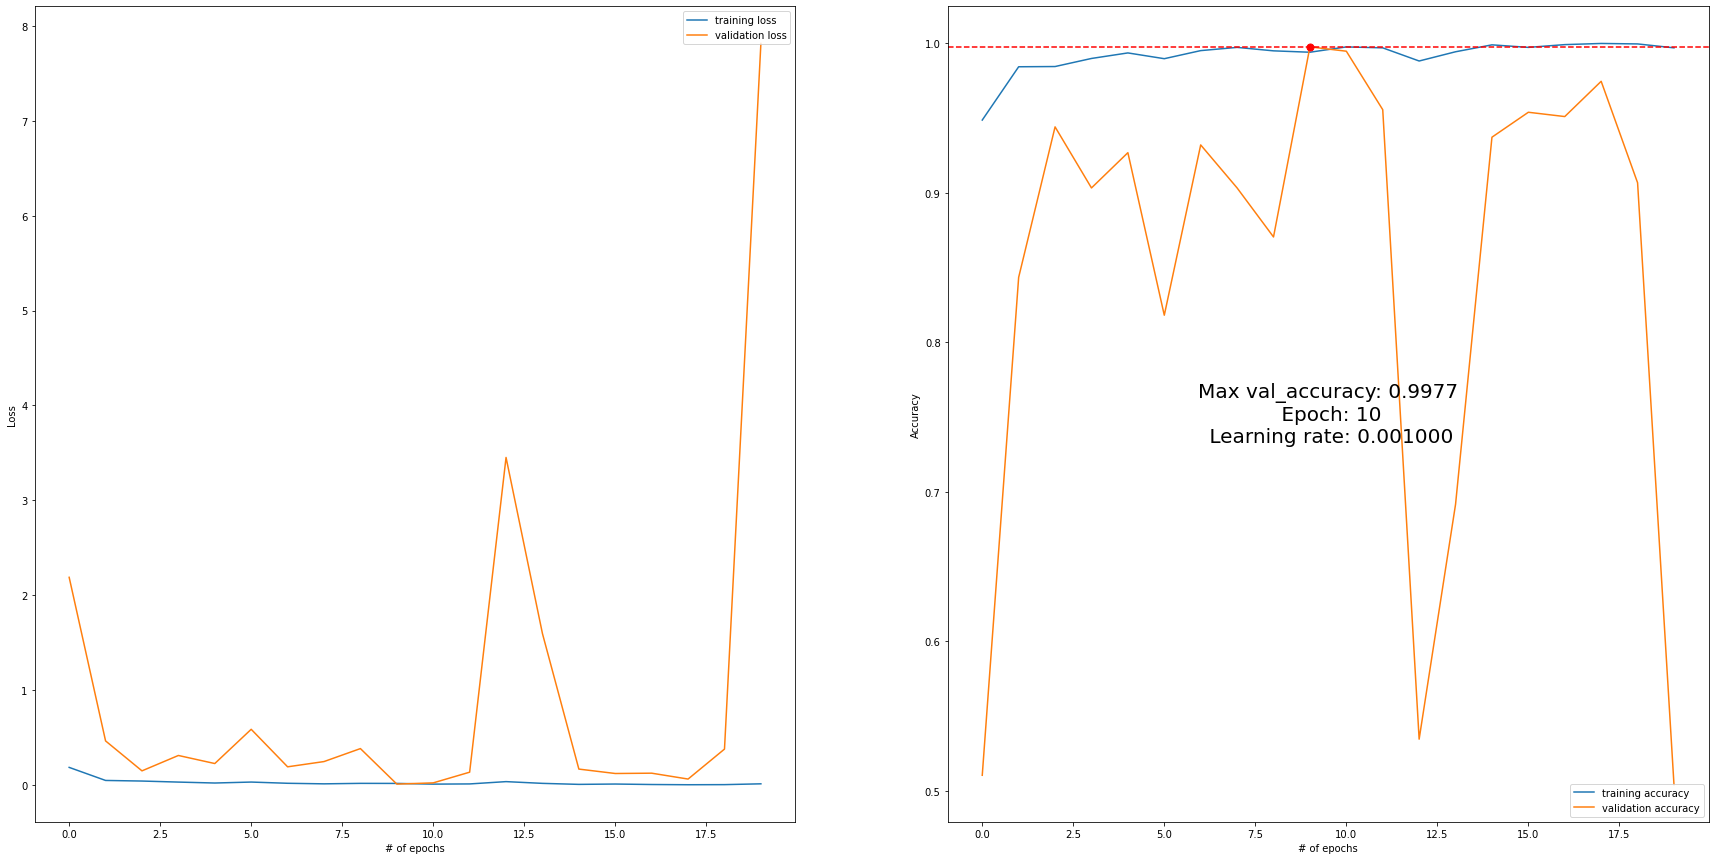

In [20]:
# Plot loss and accuracy for epochs
hist = hist1 #change to hist2 for model 2

max_val_accuracy = max(hist.history['val_accuracy'])
max_train_accuracy = max(hist.history['accuracy'])
epoch_max_val_accuracy = hist.history['val_accuracy'].index(max(hist.history['val_accuracy']))+1

fig, axs = plt.subplots(1, 2, figsize=(30,15))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].plot(hist.epoch, hist.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='upper right')
axs[0].set(xlabel = '# of epochs', ylabel = 'Loss')
axs[1].plot(hist.epoch, hist.history['accuracy'])
axs[1].plot(hist.epoch, hist.history['val_accuracy'])
axs[1].set(xlabel = '# of epochs', ylabel = 'Accuracy')

#plot the maximum accuracy as lines
axs[1].axhline(y=max_val_accuracy, color='r', linestyle='--')
#axs[1].axhline(y=max_train_accuracy, color='b', linestyle='--')

# Get the indices of the data points with max val accuracy and plot
indices = [i for i, j in enumerate(hist.history['val_accuracy']) if j == max_val_accuracy]
axs[1].plot([hist.epoch[i] for i in indices], [hist.history['val_accuracy'][i] for i in indices], 'o', color='r', markersize=7)

# Calculate the coordinates of the middle of the axs[1] as and plot accuracy as number
x_mid = (axs[1].get_xlim()[0] + axs[1].get_xlim()[1]) / 2
y_mid = (axs[1].get_ylim()[0] + axs[1].get_ylim()[1]) / 2
axs[1].text(x_mid, y_mid, f"Max val_accuracy: {max_val_accuracy:.4f}\n Epoch: {epoch_max_val_accuracy}\n Learning rate: {modelOptimizer.learning_rate.numpy():.6f}", fontsize=20, ha='center', va='center')

axs[1].legend(('training accuracy', 'validation accuracy'), loc='lower right')

plt.show()

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_ds_batch)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

##Second model

In [ ]:
# Define the input shape of the images
input_shape = (64, 256, 1) #Shape of one sample, we have 6478 samples for training!

# Define the model architecture
model2 = tf.keras.models.Sequential([
    # First convolutional layer
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, activation='relu', input_shape=input_shape),
    # Second convolutional layer
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, activation='relu'),
    # Third convolutional layer
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, activation='relu'),
    # Fourth convolutional layer
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=2, activation='relu'),
    # Flatten the output of the convolutional layers
    tf.keras.layers.Flatten(),
    # First fully connected layer
    tf.keras.layers.Dense(units=512, activation='relu'),
    # Second fully connected layer (output layer)
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

#Define optimizer
modelOptimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

# Compile the model
model2.compile(optimizer=modelOptimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model2.summary()

In [ ]:
save_path = '/content/drive/MyDrive/CAS/M6/Music_speech/models/model2/model_epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}.h5'
save_callback = tf.keras.callbacks.ModelCheckpoint(save_path, monitor='val_accuracy', save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
hist2 = model2.fit(train_ds_batch,
          epochs=20, batch_size=32, 
          validation_data=validate_ds_batch,
          callbacks=save_callback)

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model2.evaluate(test_ds)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

# Test Models on final test set

## Load models and evaluate accuracy

In [24]:
# load the model from a specific epoch
from tensorflow.keras.models import load_model
model_loaded = load_model("/content/drive/MyDrive/CAS/M6/Music_speech/models/model1/KEEP_model_epoch_15_val_acc_0.99.h5") #keep path to best model1 so far: "/content/drive/MyDrive/CAS/M6/Music_speech/models/model1/KEEP_model_epoch_15_val_acc_0.99.h5"
#model_loaded = load_model("/content/drive/MyDrive/CAS/M6/Music_speech/models/model2/KEEP_model_epoch_13_val_acc_0.98.h5") #keep path to best model2 so far: "/content/drive/MyDrive/CAS/M6/Music_speech/models/model2/KEEP_model_epoch_13_val_acc_0.98.h5"

#load bad model: (/content/drive/MyDrive/CAS/M6/Music_speech/models/model1/model_epoch_01_val_acc_0.50.h5)
#model_loaded = load_model("/content/drive/MyDrive/CAS/M6/Music_speech/models/model1/model_epoch_01_val_acc_0.50.h5")

In [25]:
# Evaluate the loaded model on the final test set
loss, accuracy = model_loaded.evaluate(test_ds_batch)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

30/30 [==============================] - 1s 13ms/step - loss: 0.0758 - accuracy: 0.9668
Test loss: 0.07583114504814148
Test accuracy: 0.9667721390724182


## Loop and predict each label from test set until first wrong prediction

In [ ]:
#Stop after first wrong prediction?
stop = 1

#plot=
plot = 0

#Define variables
n = 10000
classes_predicted = []
classes_true_label = []
sounds = []

#Shuffle the test dataset
shuffled_test_ds = test_ds.shuffle(n_test)

for i, (sound, label) in enumerate(shuffled_test_ds.take(n)):
  if plot == 1:
    plt.subplot(1,n,i+1)
    plt.imshow(sound.numpy().T)

  #Add channel dimension
  sound_ = sound
  sound = np.expand_dims(sound, axis=0)  # add batch dimension
  sound = np.expand_dims(sound, axis=-1)  # add channel dimension

  #List the sounds
  sounds.append(sound_)

  #Predict
  test_sample_pred = model_loaded.predict(sound, verbose=0)
  classes_predicted.append(test_sample_pred[0])
  classes_true_label.append(label.numpy())
  
  #Stop after first wrong prediction
  if stop == 1:
    if label.numpy() != round(test_sample_pred[0][0]):
      break

if plot == 1:
  plt.xlabel('t')
  plt.ylabel('frequency')
  plt.show()

classes_num = [num for arr in classes_predicted for num in arr]
classes_predicted = ["speech" if num > 0.5 else "music" for arr in classes_predicted for num in arr]
classes_true_label = ["music" if i == 0 else "speech" for i in classes_true_label]

print (f"Probability for speech: {classes_num}")
print (f"Predicted category: {classes_predicted}")
print (f"True label: {classes_true_label}")

#Accuracy Summary
correct_predictions = 0
wrong_predictions = 0
for true, predicted in zip(classes_true_label, classes_predicted):
    if true == predicted:
        correct_predictions += 1
    else:
        wrong_predictions += 1

print("Number of correct predictions:", correct_predictions)
print("Number of wrong predictions:", wrong_predictions)
print("Accuracy:", correct_predictions / len(classes_true_label))


Probability for speech: [0.98456997, 1.0, 2.527888e-10, 0.9600201, 0.99919957, 4.615727e-05, 5.2664174e-05, 9.786358e-05, 0.9994867, 0.9996842, 0.17129368, 0.9999945, 9.366752e-06, 0.9997881, 5.5680443e-06, 0.9551923, 0.9999292, 0.04804025, 0.97964305, 0.99964106, 0.9958216, 0.022359751, 1.4625265e-06, 0.025840042, 0.0029081712, 0.02239652, 0.99408853, 0.94476426, 0.80876225, 1.0, 8.7142564e-07, 3.2893074e-06, 1.1150973e-05, 0.99997735, 1.6902998e-08, 2.0878963e-06, 0.999808, 0.0010936267, 0.061408892, 3.3366155e-07, 9.4655e-08, 0.00014201294, 1.8625741e-08, 3.5445541e-06, 0.9947461, 0.9999832, 0.13207777, 0.9999522, 0.99963844, 0.9999802, 1.0, 9.545933e-05, 1.4884017e-05, 0.9999999, 7.190198e-07, 0.9999167, 0.94699085, 1.0, 0.00015432629, 0.9719177, 0.9988594, 0.00039506383, 0.00060720695, 1.1972315e-07, 0.9999819, 0.91616946, 6.222542e-05, 0.99999917, 0.9848797, 1.3257244e-05, 2.555641e-07, 0.31447446]
Predicted category: ['speech', 'speech', 'music', 'speech', 'speech', 'music', 'mu

Label: 1.0, Prediction: 0.3144744634628296


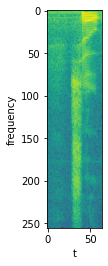

In [ ]:
#Plot the spectrogram of the first wrong prediction (variable stop in the previous code block has to be 1)
print(f"Label: {label.numpy()}, Prediction: {test_sample_pred[0][0]}")
plt.imshow(sound_.numpy().T)
plt.xlabel('t')
plt.ylabel('frequency')
plt.show;

Typical music spectogram in the sense of the model.
Prediction = 2.527887899006487e-10


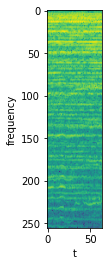

In [ ]:
#Plot the spectrogram with the hightest probablitity for music according to the model
indexMin = classes_num.index(min(classes_num))

print(f"Typical {classes_true_label[indexMin]} spectogram in the sense of the model.\nPrediction = {classes_num[indexMin]}")
plt.imshow(sounds[indexMin].numpy().T);
plt.xlabel('t')
plt.ylabel('frequency')
plt.show;
#Possible explanation: high-frequency components are often associated with sounds that are perceived as being "bright" or "sharp," such as cymbals or the upper harmonics of a guitar or piano.

Typical speech spectogram in the sense of the model. Prediction = 1.0


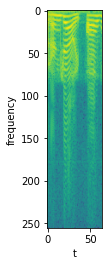

In [ ]:
#Plot the spectrogram with the hightest probablitity for speech according to the model
indexMax = classes_num.index(max(classes_num))

print(f"Typical {classes_true_label[indexMax]} spectogram in the sense of the model. Prediction = {classes_num[indexMax]}")
plt.imshow(sounds[indexMax].numpy().T)
plt.xlabel('t')
plt.ylabel('frequency')
plt.show;